In [2]:
class naturalSceneText:
    import numpy as np
    import cv2
    import imutils.object_detection
    import pytesseract
    from matplotlib import pyplot as plt
    
    def __init__ (self, min_confidence=0.8, height=320, width=320):
        self.min_confidence = min_confidence
        self.height = height
        self.width = width
        self.east = "../Pre-trained/frozen_east_text_detection.pb"
        return
    
    def normalize(self, image):
        norm_img = self.np.zeros((image.shape[0], image.shape[1]))
        return self.cv2.normalize(image, norm_img, 0, 255, self.cv2.NORM_MINMAX)
    def get_grayscale(self, image):
        return self.cv2.cvtColor(image, self.cv2.COLOR_BGR2GRAY)
    def remove_noise(self, image):
        return self.cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 15)
    
    def preProcess(self, image):
        imgn = self.normalize(image)
        imgr = self.remove_noise(imgn)
        img = self.get_grayscale(imgr)
        return img
    
    # Returns a bounding box and probability score if it is more than minimum confidence
    def predictions(self, prob_score, geo):
        (numR, numC) = prob_score.shape[2:4]
        boxes = []
        confidence_val = []
        # loop over rows
        for y in range(0, numR):
            scoresData = prob_score[0, 0, y]
            x0 = geo[0, 0, y]
            x1 = geo[0, 1, y]
            x2 = geo[0, 2, y]
            x3 = geo[0, 3, y]
            anglesData = geo[0, 4, y]
            # loop over the number of columns
            for i in range(0, numC):
                if scoresData[i] < self.min_confidence:
                    continue
                (offX, offY) = (i * 4.0, y * 4.0)
                # extracting the rotation angle for the prediction and computing the sine and cosine
                angle = anglesData[i]
                cos = self.np.cos(angle)
                sin = self.np.sin(angle)
                # using the geo volume to get the dimensions of the bounding box
                h = x0[i] + x2[i]
                w = x1[i] + x3[i]
                # compute start and end for the text pred box
                endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
                endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
                startX = int(endX - w)
                startY = int(endY - h)
                boxes.append((startX, startY, endX, endY))
                confidence_val.append(scoresData[i])
        return (boxes, confidence_val)
    
    def getText(self, src):
        img = self.cv2.imread(src)
        image = self.preProcess(img)
        image = self.cv2.cvtColor(image, self.cv2.COLOR_BGR2RGB)
        orig = image.copy()
        (origH, origW) = image.shape[:2]
        (newW, newH) = (self.width, self.height)
        rW = origW / float(newW)
        rH = origH / float(newH)
        image = self.cv2.resize(image, (newW, newH))
        (H, W) = image.shape[:2]
        blob = self.cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
        
        # load the pre-trained EAST model for text detection 
        net = self.cv2.dnn.readNet(self.east)
        # We would like to get two outputs from the EAST model. 
        #1. Probabilty scores for the region whether that contains text or not. 
        #2. Geometry of the text -- Coordinates of the bounding box detecting a text
        # The following two layer need to pulled from EAST model for achieving this. 
        layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
        
        #Forward pass the blob from the image to get the desired output layers
        net.setInput(blob)
        (scores, geometry) = net.forward(layerNames)
        
        # Find predictions and apply non-maxima suppression
        (boxes, confidence_val) = self.predictions(scores, geometry)
        boxes = self.imutils.object_detection.non_max_suppression(self.np.array(boxes), probs=confidence_val)
        
        ##Text Detection and Recognition 
        results = []
        # loop over the bounding boxes to find the coordinate of bounding boxes
        for (startX, startY, endX, endY) in boxes:
            # scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
            startX = int(startX * rW)
            startY = int(startY * rH)-5
            endX = int(endX * rW)
            endY = int(endY * rH)+5
            #extract the region of interest
            r = orig[startY:endY, startX:endX]
            #configuration setting to convert image to string.  
            configuration = ("-l eng --oem 1 --psm 8")
            #This will recognize the text from the image of bounding box
            text = self.pytesseract.image_to_string(r, config=configuration)
            # append bbox coordinate and associated text to the list of results 
            results.append(((startX, startY, endX, endY), text))
            
        orig_image = img.copy()
        texts = []
        for ((start_X, start_Y, end_X, end_Y), text) in results:
            text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
            texts.append([start_Y, text])
            self.cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y), (155, 155, 155), 2)
            self.cv2.putText(orig_image, text, (start_X, start_Y - 10), self.cv2.FONT_HERSHEY_SIMPLEX, 0.8,(0,0,0), 2)
        texts.sort()
        for i in texts:
            print(f'{i[1]}')
        self.plt.figure(figsize=(10,10))
        self.plt.imshow(orig_image)
        self.plt.title('Output')
        self.plt.show()

In [3]:
nst = naturalSceneText()

PHARMACIST
KIM
476
13
1609


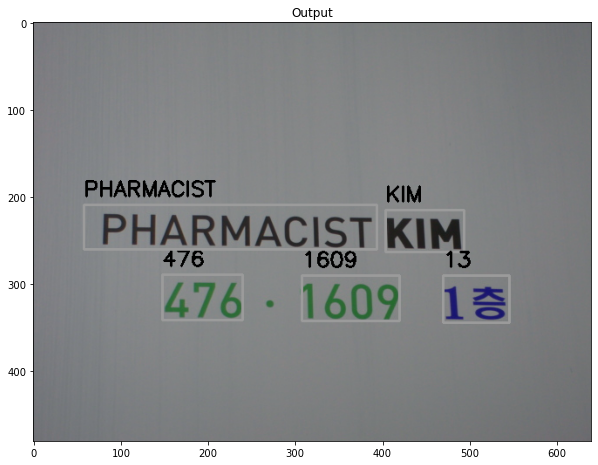

In [4]:
nst.getText("data/nstext/DSC03650.JPG")

Odyssey


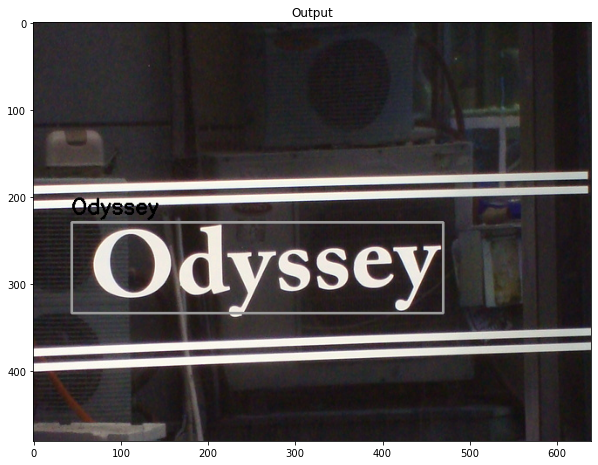

In [5]:
nst.getText("data/nstext/DSC03200.JPG")

THE!
NORTH
FACE


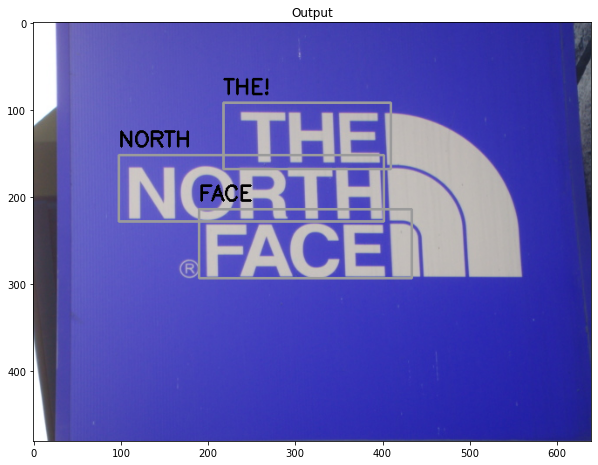

In [6]:
nst.getText("data/nstext/DSC03264.JPG")

In [6]:
# nst.getText("data/nstext/DSC03290.JPG")

In [7]:
# nst.getText("data/nstext/DSC04120.JPG")

In [8]:
# nst.getText("data/nstext/DSC04035.JPG")

In [9]:
# nst.getText("data/nstext/DSC04430.JPG")

In [10]:
# nst.getText("data/nstext/DSC04313.JPG")